# Adjusting FCN with Keras

In the previous tutorial we covered the basic workflow for building, compiling, training and testing NN with Keras, however each of these steps can be customized to tweak the model and achieve better results. In this tutorial, we'll introduce some of these adjustable features before applying them to an image classification task.

## Weight Initialization

By default, Keras uses Glorot initialization with a uniform distribution to assign the initial layer's weights. When creating a layer, you can change this behaviour via the `kernel_initializer` parameter to either `"he_uniform"`, `"he_normal"` or `"lecun_normal"`.

Additionally, you can define your own initialization scheme through the `VarianceScaling` initializer. For example, we might define a He initialization with a uniform distribution, but based on $fan_{avg}$ instead of $fan_{in}$ like this:

```python
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                 distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)
```

For more information check the documentation: https://keras.io/api/layers/initializers/

## Activation Functions ##

Activation functions can be directly specified by the `activation` argument when creating a layer (if omitted no activation function is used) or added directly to the model as an `ActivationLayer`. Built-in activation functions can be simply passed through their string identifier (for instance `'relu'` for `keras.activations.relu`).

The following 3 examples all add a dense 10-neuron layer with a ReLU activation function:

```python
model.add(keras.layers.Dense(10, activation="relu"))
```
```python
model.add(keras.layers.Dense(10, activation=keras.activations.relu))
```
```python
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation(keras.activations.relu))
```

Additionally, you can customize existing activation functions through their respective initializers.

You can check all available activation functions in the documentation: https://keras.io/api/layers/activations/


## Optimizers

An optimizer is one of the two arguments required for compiling a Keras model (the other being a Loss function). You can either instantiate an optimizer before passing it to `model.compile()`, or you can pass it by its string identifier. For example, the following two code snippets have the same result:

```python
opt = keras.optimizers.SGD()
model.compile(loss='categorical_crossentropy', optimizer=opt)
```
```python
model.compile(loss='categorical_crossentropy', optimizer='sgd')
```

However, instantiating the optimizer allows us to specify different parameters than the default ones. For instance, we can specify the use of momentum on a simple SGD optimizer via the `momentum` parameter.

```python
keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
```

We can also use Nesterov momentum by simply setting the `nesterov` parameter to `True`.

```python
keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
```

Further, we can set a learning rate schedule to establish how the learning rate of our optimizer changes over time.

```python
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
```

We can also choose a different optimizer by using the corresponding class.

```python
# RMSProp
keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# Adam
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
```

A full list of available optimizers can be found in the documentation: https://keras.io/api/optimizers/

## Batch Normalization ##

A batch normalization layer normalizes its inputs. Typically used so the output of a layer is normalized before feeding it into the next layer. Batch normalization can be easily used in Keras by adding a `BatchNormalization` layer anywhere in your model. Normally, we use BN layers before or after a hidden layer's activation function and/or as the first layer of the model.

```python
model.add(keras.layers.BatchNormalization())
```

BN layers will behave slightly different during training and inference (predicting). During training, the layer normalizes its output using the mean and standard deviation of the current batch of inputs. During inference, the layer normalizes its output using a moving average of the mean and standard deviation of the batches it has seen during training.

You can read more about BN in the documentation: https://keras.io/api/layers/normalization_layers/batch_normalization/

## Gradient Clipping

To implement gradient clipping in Keras we only need to set the `clipvalue` argument when creating an optimizer. For example, the following code will clip every component of the gradient vector to a value between -1.0 and 1.0.

```python
keras.optimizer.SGD(clipvalue=1.0)
```

## Regularization

Regularization terms can be added to a layer through the `kernel_regularizer` parameter to either `keras.regularizers.l1()`, `keras.regularizers.l2()` or `keras.regularizers.l1_l2()`.

```python
keras.layers.Dense(100,activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))
```

## Dropout

A Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by $1/(1 - rate)$ such that the sum over all inputs is unchanged.

To implement droput in Keras we simply add a `Dropout` layer before each layer.

```python
model.add(keras.layers.Dropout(rate=0.03))
```

Like `BatchNormalization`, `Dropout` layers exhibit a different behaviour during training than inference. In short, `Dropout` layers will only block out inputs during training, and will be disablaed during inference.

For more on Dropout layers check the documentation: https://keras.io/api/layers/regularization_layers/dropout/

## Callbacks ##

The `fit()` method accepts a `callbacks` argument that lets us specify a list of objects that Keras will call at different intervals (before/after training, each epoch or each batch).

`EarlyStopping`, for instance, will automatically interrupt training when it measures no progress on the validation set for a certain number of epochs (defined via the `patience` parameter), and it will optionally roll back to the best model at the end (if `restore_best_weights` is set to `True`).

```python
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping_cb])
```

Another useful callback is [`ModelCheckpoint`](https://keras.io/api/callbacks/model_checkpoint/), which allows us to define an interval to automatically save a model or its weights. This is fundamental if we want save a trained model for later use, pick up training at a later date or ensure progress isn't lost in case of a disconnection when working in the cloud ([`BackUpAndRestore`](https://keras.io/api/callbacks/backup_and_restore/) callback can also be used for this purpose).

```python
model.compile(loss=..., optimizer=...,
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model.fit(epochs=..., callbacks=[model_checkpoint_callback])
```

For instance, the previous code example will save the model's weights at the end of each epoch only if the `val_accuracy` obtained was greater than the current best (overwriting the previous best weights). `ModelCheckpoint` can be configured to also save the model's definition (`save_weights_only=False`), save every N batches (`save_freq=N`) or save every weight configuration (`save_best_only=False`), among others.

Saved weights can be later loaded using the `load_weights()` method. Notice that if we only saved the weights of the model, we'll need to rebuild the model first using the exact same architecture (if we saved the entire model, we can load it using `keras.models.load_model()` instead).
```python
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)
```

There are several different predefined callbacks we can use or even define our own. You can read more about callbacks in the documentation: https://keras.io/api/callbacks/

## Saving and Loading ##

You can also manually save a model at any time using the `save` method of the `Model` class or the `save_model` function from the `keras.saving` package.

```
model = keras.models.Sequential(...)
model.save('model.keras')
// Alternatively
keras.saving.save_model(model, 'model.keras')
```

Similarly, models can be loaded using the `load_model` function from the same `keras.saving` package.

```
model = keras.saving.load_model('model.keras')
```

You can read more about it in the [official documentation](https://keras.io/2.16/api/models/model_saving_apis/model_saving_and_loading/) and the [serialization and saving guide](https://keras.io/guides/serialization_and_saving/).



## Practice

For this practice exercise we'll build a 'simple' multilayer neural network classifier for the [FMNIST dataset](https://keras.io/api/datasets/fashion_mnist/). The FMNIST dataset is a collection of 70,000 grayscale images of clothing items of  $28\times 28$  pixels each.


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

The dataset is already divided into 60,000 images for training and 10,000 for testing. Don't forget to reserve 10% of your data as a validation set (you can set it up manually or through the `validation_split` parameter in `fit()`).

In [2]:
fmnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fmnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We can now check the properities of our loaded dataset by reviewing its shape. Keras will load the features dataset with every image represented as a $28 \times 28$ array, and each pixel intensity represented by an integer between 0 and 255.

The class label will simply correspond to the clothing category (0 to 9) according to the following key:

0.	T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

In [3]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
           'Sneaker','Bag','Ankle boot']

In [4]:
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


Finally, we'll scale the range of the pixel values from $[0-255]$ into $[0-1]$.

In [5]:
X_train = X_train / 255
X_test = X_test / 255

We can visualize a sample image from the dataset with its corresponding label.

y = Sandal


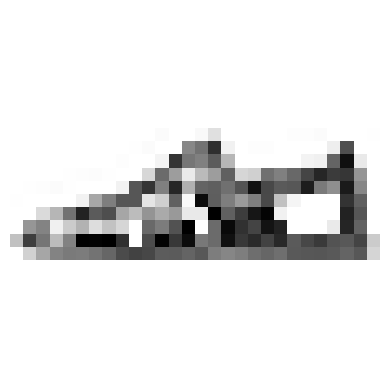

In [9]:
# Example of a picture, change the index to visualize different pictures
index = 201
plt.imshow(X_train[index], cmap='Greys')
plt.axis('off')
print("y = " + classes[y_train[index]])

Lastly, we'll define a function to easily visualize training results.

In [10]:
def plot_results(history):
  fig, (ax1, ax2) = plt.subplots(2)
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.legend(['train_acc', 'val_acc'], loc='upper left')

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.legend(['train_loss', 'val_loss'], loc='upper left')

### Building the model
Build a Sequential fully connected NN to classify images into their corresponding category. Notice that, since the input images have a $(28, 28)$ shape, we'll need to first "flatten" them into a $(784, 1)$ feature vector. We can use a [`Flatten` layer](https://keras.io/api/layers/reshaping_layers/flatten/) at the start of our model to achieve this. Don't forget to add an [`Input` layer](https://keras.io/api/layers/core_layers/input/) as the first layer in your model to specify the input's shape.

Next add some hidden dense layers. Use `He_normal` initialization and the `ELU` activation function. Make it a 'big' network with at least 10 hidden layers of 100 neurons each.

When adding several similar layers, we can use the `add()` method of the `model` inside of a loop. For instance:

```python
model = keras.models.Sequential()
for i in range(10):
  model.add(keras.layers.Dense())
```

For the output layer, you'll need 10 units with a `softmax` activation, since the dataset has 10 different classes with no overlapping.

In [ ]:
model1 =

### Compiling and training the model

Using `SGD` optimization with Nesterov momentum and [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as your loss function, train the network on the FMNIST dataset for 50 epochs. Notice we need to use `sparse_categorical_crossentropy` instead of `categorical_crossentropy` since our targets are given as an integer between $[0-9]$.

Plot your results.


Feel free to experiment with different learning rates and momentums, plot each configuration's results and compare them. If you notice the network might be underfitting, go back and increase its capacity.

Repeat the experiment using `Nadam` optimization and early stopping (with `patience=10` and restroring the best weights). Does it produce a better model?
Note that since we'll be using early stopping, you can crank up the total number of epochs, knowing that the model won't be overfitted.

In [ ]:
keras.backend.clear_session() # Resets all states created by keras, advisable when creating many models to free memory
# Create the model again so weights are initilized back to random
model2 = ...

Now try adding `BatchNormalization` layers before each hidden layers' activation function (as well as after the `Flatten` layer) and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

In [ ]:
keras.backend.clear_session()
# Create the model again so weights are initilized back to random
model3 = ...

Try regularizing the model with dropout by adding `Dropout` layers. See if you can achieve better accuracy (experiment with their number, placement and `rate`). Include a `ModelCheckpoint` callback to save your model's best weights.

In [ ]:
keras.backend.clear_session()
# Create the model again so weights are initilized back to random
model4 = ...

Finally, test your chosen model using the test set. Did you get a good result?